In [1]:
from pathlib import Path
import sys

# Allow running without installing the package
ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT / "src" / "sinterpy").exists():
    ROOT = ROOT.parent
if (ROOT / "src" / "sinterpy").exists():
    sys.path.insert(0, str(ROOT / "src"))
else:
    raise RuntimeError("Could not find src/sinterpy; open notebook from within the repo.")

#custom libs
from sinterpy.losses import HuberLoss, L2Loss, L1Loss
from sinterpy.operators import AcousticStationaryOperator
from sinterpy.objective import ModelBasedObjective, SparseSpikeObjective
from sinterpy.utils import ricker_wavelet, butter_lowpass_filter

#common libs
from time import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


Success: True
Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
nit: 86 nfev: 100
||x_est - x_true||: 0.8211149573326111


C:\Users\Владислав\AppData\Local\Temp\ipykernel_6780\1011600632.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


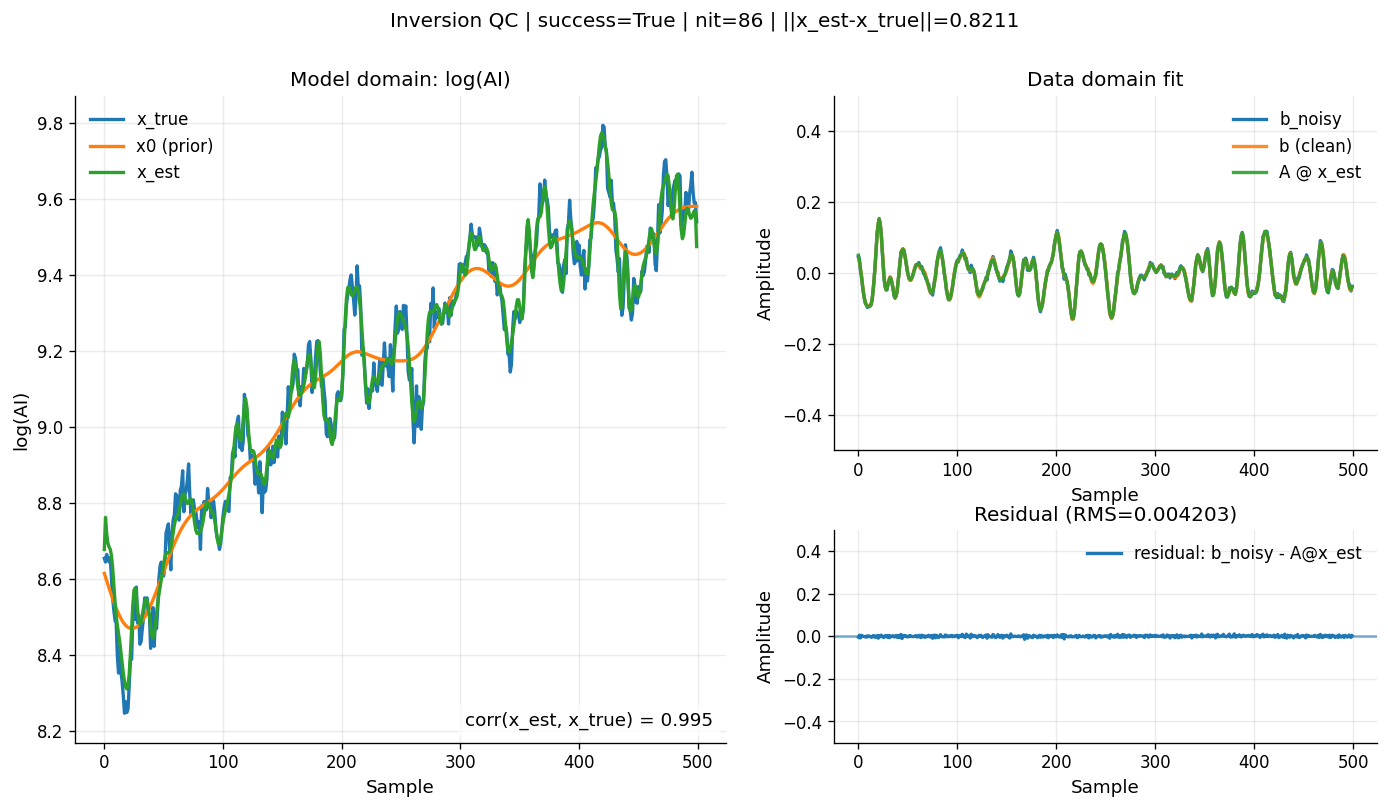

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.random.seed(42)

# ------------------------- toy forward model -------------------------
def predict(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=np.float32).ravel()
    return A @ x

def predict_grad(x: np.ndarray):
    return A

# ------------------------- synthetic "true" model -------------------------
nt = 500
z = np.linspace(0.0, 1.0, nt).astype(np.float32)

trend = (5000.0 + 10000.0 * z).astype(np.float32)

noise = np.random.normal(0.0, 1.0, nt).astype(np.float32)
noise = np.convolve(noise, np.ones(15, dtype=np.float32) / 15.0, mode="same").astype(np.float32)

imp = trend * (1.0 + 0.50 * noise)
imp = np.clip(imp, 1.0, None).astype(np.float32)

x_true = np.log(imp).astype(np.float32)

wavelet = ricker_wavelet(f_hz=25.0, dt=0.002, nt=128).astype(np.float32)
A = AcousticStationaryOperator(wavelet=wavelet, nt=nt, dtype=np.float32, sparse=True)

b = A @ x_true
b_noisy = (b + np.random.normal(0.0, 0.005, size=b.shape).astype(np.float32)).astype(np.float32)

# ------------------------- objective -------------------------
x_prior = butter_lowpass_filter(x_true, cutoff=6, fs=500, order=2).astype(np.float32)

data_loss = L2Loss()
reg_loss = HuberLoss(delta=np.float32(1.345))
# reg_loss = L1Loss()  # uncomment to use L1 regularization instead of Huber
# lam = 5e-3
lam = 1e-3

obj = ModelBasedObjective(
    predict=predict,
    predict_grad=predict_grad,
    real=b_noisy,
    prior=x_prior,
    misfit_loss=data_loss,
    mbi_loss=reg_loss,
    lam=lam,
)

# ------------------------- SciPy L-BFGS-B minimize -------------------------

res = minimize(
    fun=lambda x: np.float32(obj(x)),
    x0=x_prior,
    jac=lambda x: obj.gradient(x).astype(np.float32),
    method="L-BFGS-B",
    options=dict(maxiter=500, ftol=1e-12, gtol=1e-12),
)

x_est = res.x.astype(np.float32)

print("Success:", res.success)
print("Message:", res.message)
print("nit:", res.nit, "nfev:", res.nfev)
print("||x_est - x_true||:", float(np.linalg.norm(x_est - x_true)))

# ------------------------- visualization -------------------------
b_est = predict(x_est).astype(np.float32)
t = np.arange(nt, dtype=np.float32)

# style
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "-",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.frameon": False,
    "lines.linewidth": 2.0,
})

fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(2, 2, height_ratios=[2.0, 1.2], width_ratios=[1.2, 1.0], hspace=0.28, wspace=0.18)

ax1 = fig.add_subplot(gs[:, 0])   # full left (model domain)
ax2 = fig.add_subplot(gs[0, 1])   # top-right (data domain)
ax3 = fig.add_subplot(gs[1, 1])   # bottom-right (residual)
# correlation coefficient between estimate and true model
corr = np.corrcoef(x_true, x_est)[0, 1]

# Model domain
ax1.plot(t, x_true, label="x_true")
ax1.plot(t, x_prior, label="x0 (prior)")
ax1.plot(t, x_est, label="x_est")
ax1.set_title("Model domain: log(AI)")
ax1.set_xlabel("Sample")
ax1.set_ylabel("log(AI)")
ax1.legend(loc="best")

ax1.text(
    0.98, 0.02,
    f"corr(x_est, x_true) = {corr:.3f}",
    transform=ax1.transAxes,
    ha="right",
    va="bottom",
    fontsize=11,
    bbox=dict(facecolor="white", alpha=0.75, edgecolor="none")
)

# Data domain
ax2.plot(t, b_noisy, label="b_noisy")
ax2.plot(t, b, label="b (clean)", alpha=0.9)
ax2.plot(t, b_est, label="A @ x_est", alpha=0.9)
ax2.set_title("Data domain fit")
ax2.set_xlabel("Sample")
ax2.set_ylabel("Amplitude")
ax2.set_ylim(-0.5, 0.5)
ax2.legend(loc="best")

# Residual
resid = (b_noisy - b_est).astype(np.float32)
ax3.plot(t, resid, label="residual: b_noisy - A@x_est")
ax3.axhline(0.0, linewidth=1.5, alpha=0.6)
ax3.set_title(f"Residual (RMS={float(np.sqrt(np.mean(resid**2))):.4g})")
ax3.set_xlabel("Sample")
ax3.set_ylabel("Amplitude")
ax3.set_ylim(-0.5, 0.5)
ax3.legend(loc="best")

fig.suptitle(
    f"Inversion QC | success={res.success} | nit={res.nit} | ||x_est-x_true||={float(np.linalg.norm(x_est-x_true)):.4g}",
    y=0.98,
)

plt.tight_layout()
plt.show()


SSI Success: True
SSI Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
SSI nit: 127 nfev: 149
SSI ||x_est - x_true||: 0.8992519378662109


C:\Users\Владислав\AppData\Local\Temp\ipykernel_6780\2657674819.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


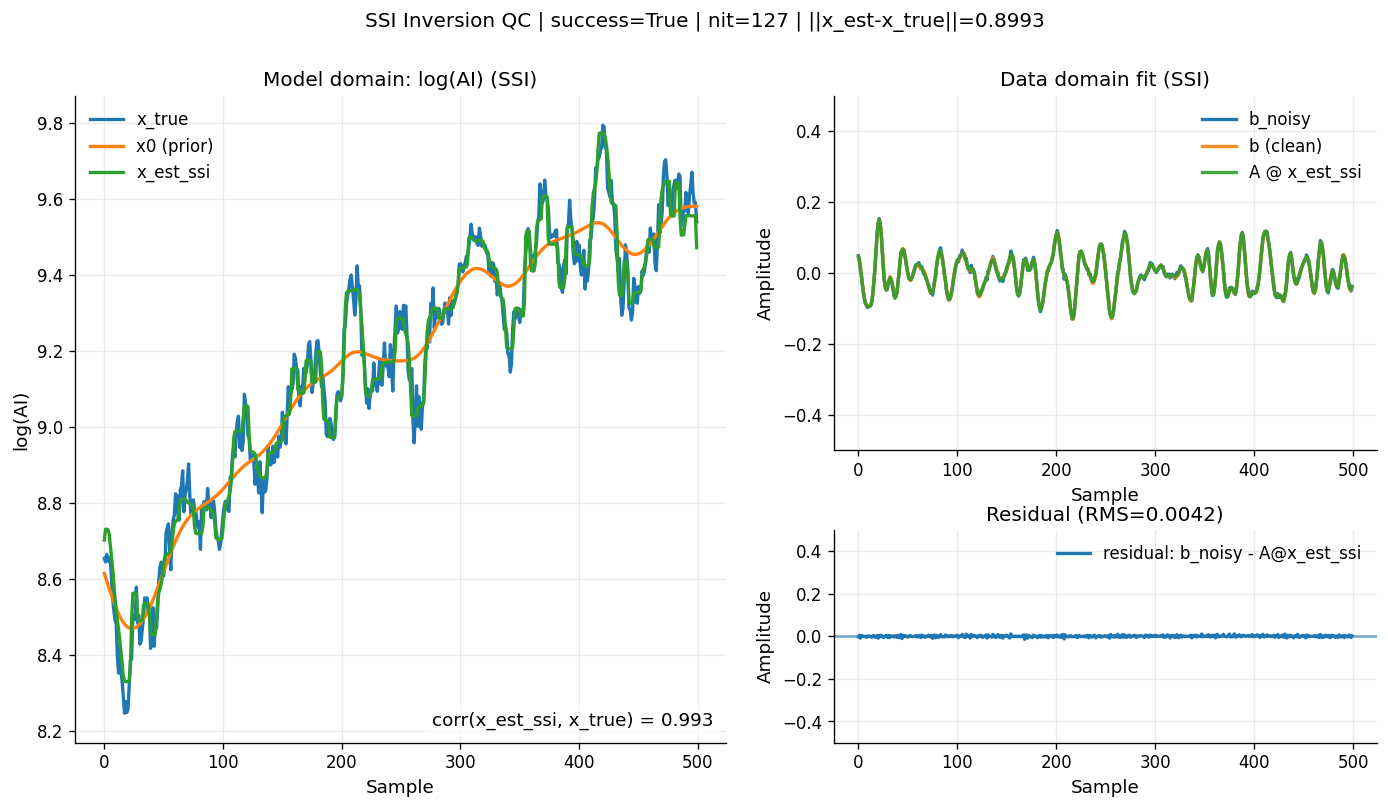

In [9]:
# ------------------------- Sparse Spike Objective -------------------------

ssi_obj = SparseSpikeObjective(
    predict=predict,
    predict_grad=predict_grad,
    real=b_noisy,
    prior=x_prior,
    misfit_loss=data_loss,
    mbi_loss=reg_loss,
    mbi_lam=5e-4,
    ssi_loss=L1Loss(),
    ssi_lam=1e-4,
)

ssi_res = minimize(
    fun=lambda x: np.float32(ssi_obj(x)),
    x0=x_prior,
    jac=lambda x: ssi_obj.gradient(x).astype(np.float32),
    method="L-BFGS-B",
    options=dict(maxiter=500, ftol=1e-12, gtol=1e-12),
)

x_est_ssi = ssi_res.x.astype(np.float32)

print("SSI Success:", ssi_res.success)
print("SSI Message:", ssi_res.message)
print("SSI nit:", ssi_res.nit, "nfev:", ssi_res.nfev)
print("SSI ||x_est - x_true||:", float(np.linalg.norm(x_est_ssi - x_true)))

# ------------------------- visualization (SSI) -------------------------
b_est_ssi = predict(x_est_ssi).astype(np.float32)
t = np.arange(nt, dtype=np.float32)

fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(2, 2, height_ratios=[2.0, 1.2], width_ratios=[1.2, 1.0], hspace=0.28, wspace=0.18)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

corr_ssi = np.corrcoef(x_true, x_est_ssi)[0, 1]

ax1.plot(t, x_true, label="x_true")
ax1.plot(t, x_prior, label="x0 (prior)")
ax1.plot(t, x_est_ssi, label="x_est_ssi")
ax1.set_title("Model domain: log(AI) (SSI)")
ax1.set_xlabel("Sample")
ax1.set_ylabel("log(AI)")
ax1.legend(loc="best")

ax1.text(
    0.98, 0.02,
    f"corr(x_est_ssi, x_true) = {corr_ssi:.3f}",
    transform=ax1.transAxes,
    ha="right",
    va="bottom",
    fontsize=11,
    bbox=dict(facecolor="white", alpha=0.75, edgecolor="none")
)

ax2.plot(t, b_noisy, label="b_noisy")
ax2.plot(t, b, label="b (clean)", alpha=0.9)
ax2.plot(t, b_est_ssi, label="A @ x_est_ssi", alpha=0.9)
ax2.set_title("Data domain fit (SSI)")
ax2.set_xlabel("Sample")
ax2.set_ylabel("Amplitude")
ax2.set_ylim(-0.5, 0.5)
ax2.legend(loc="best")

resid_ssi = (b_noisy - b_est_ssi).astype(np.float32)
ax3.plot(t, resid_ssi, label="residual: b_noisy - A@x_est_ssi")
ax3.axhline(0.0, linewidth=1.5, alpha=0.6)
ax3.set_title(f"Residual (RMS={float(np.sqrt(np.mean(resid_ssi**2))):.4g})")
ax3.set_xlabel("Sample")
ax3.set_ylabel("Amplitude")
ax3.set_ylim(-0.5, 0.5)
ax3.legend(loc="best")

fig.suptitle(
    f"SSI Inversion QC | success={ssi_res.success} | nit={ssi_res.nit} | ||x_est-x_true||={float(np.linalg.norm(x_est_ssi-x_true)):.4g}",
    y=0.98,
)

plt.tight_layout()
